# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Bertrand Lebichot - __[Bertrand.Lebichot@ulb.ac.be](mailto:Bertrand.Lebichot@ulb.ac.be)__
### Jacopo De Stefani - __[Jacopo.De.Stefani@ulb.ac.be](mailto:Jacopo.De.Stefani@ulb.ac.be)__
### Arnaud Pollaris - __[Arnaud.Pollaris@ulb.ac.be](mailto:Arnaud.Pollaris@ulb.ac.be)__
### Gianluca Bontempi - __[gbonte@ulb.ac.be](mailto:gbonte@ulb.ac.be)__

## TP 4 - Predictions: Tree-based methods

####  April 02, 2019

## Goal and dataset

The goal is to review some ML concepts :
* Classification trees
* Ensemble methods : Random forests
* Ensemble methods : Adaboost

The chosen database is about spam detection. Details can be found here :
https://archive.ics.uci.edu/ml/datasets/spambase

To import the dataset, just use package ''nutshell'' (uncomment install line if required).

Never forget that reading the documentation is useful :
*? name_of_function* or *help(name_of_function)* 

In [1]:
#install.packages("nutshell", repos = "http://cran.rstudio.com")
library("nutshell")
data(spambase)

Loading required package: nutshell.bbdb
Loading required package: nutshell.audioscrobbler


## Classification vs regression

Both classification and regression are sub-field of *supervised learning*. In the two cases, we have predictive variables $X$ and a target variable $y$. The learning is said to be supervised because we use the actual value of $y$ for each samples in the training process.

In regression, $y$ is assumed to be a continuous variable. In classification however, $y$ is assumed to be a discrete variable.

The goal of a classification task is to automatically assign data to predefined discrete
classes (where $C$ is the number of classes). 

Here is a toy example :
* Knowing the two abstract features F1 and F2, and six samples for both class (the red class and the blue class), can you predict the label for the green sample ?


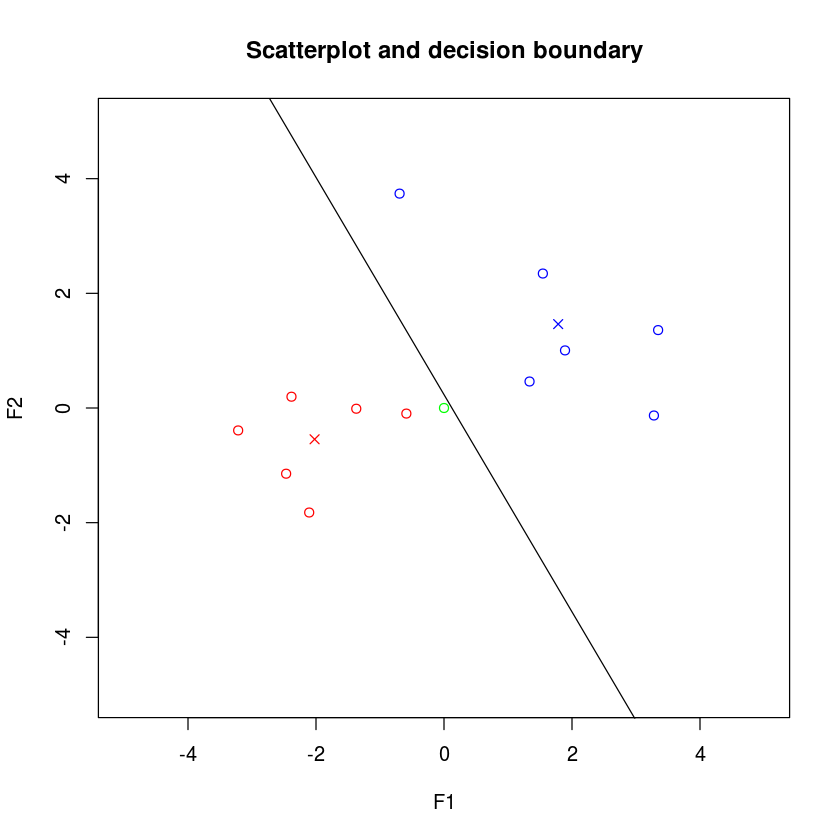

In [2]:
n = 6

# blue class data
F1 = rnorm(n, mean = +2, sd = 1)
F2 = rnorm(n, mean = +1, sd = 1)
SamplesBLUE = data.frame(F1, F2)
gBLUE = c(mean(F1),mean(F2))

# red class data
F1 = rnorm(n, mean = -2, sd = 1)
F2 = rnorm(n, mean = -1, sd = 1)
SamplesRED = data.frame(F1, F2)
gRED = c(mean(F1),mean(F2))

# draw scatterplot
plot(SamplesBLUE$F1,SamplesBLUE$F2,col="blue",main="Scatterplot and decision boundary",xlab="F1",ylab="F2",xlim=c(-5,5),ylim=c(-5,5))
points(SamplesRED$F1,SamplesRED$F2,col="red")
points(0,0,col="green")

# draw centroid of classes
points(gBLUE[1],gBLUE[2],col="blue",pch = 4)
points(gRED[1],gRED[2],col="red",pch = 4)

# draw decision boundary
midgg = c(gRED[1]+abs(gBLUE[1]-gRED[1])/2,gRED[2]+abs(gBLUE[2]-gRED[2])/2)
slope = -(gBLUE[1]-gRED[1])/(gBLUE[2]-gRED[2])
abline(a=midgg[2]-slope*midgg[1],b=slope)


### Confusion Matrix : 

In a two class setting, the confusion matrix (reporting the number of actual class / predicted class) have four entries:
 
|            | Predicted False   | Predicted True  |
|:----------:|-------------------|-----------------|
|Actual False|  True Negative TN |False Positive FP|
|Actual True | False Negative FN |True Positive TP |

## Classification trees : the basics

A decision tree (DT) partitions the input space into mutually exclusive regions (the divide-and-conquer approach). Therefore DT are easy to interpret.

DT nodes can be classified in internal nodes, determining which child node to visit next, or terminal nodes, partitioning the input space. 

In classification trees (regression trees also exist), the terminal nodes contain a label that indicates the class for the associated input region. To classify, each new sample is presented to the DT root node of the branch to one of the root’s children. The procedure is repeated recursively until a leaf. The sample is then classified as the label of that leaf.

The DT learning procedure has two steps known as *tree growing* and *tree pruning*.

* During *tree growing*, an iterative, exhaustive, search is performed to find the successive splits that best reduces a certain cost function.

    * The gini impurity (used in CART) : how often a randomly chosen element would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. It is minimum (zero) for class-homogeneous nodes.
    
    \begin{equation}
         Gini = \sum_{i=1}^C p_i * (1-p_i) = 1-\sum_{i=1}^C p_i^2\\
    \end{equation}

    * The information gain (IG, used in ID3,C4.5) : based on the concept of entropy and information content from information theory. Basically the IG is the entropy of the parent node minus the weighted sum of the children node entropy.

    \begin{equation}
         IG = -\sum_{i=1}^C p_i * log_2 (p_i) - \sum_{a} p(a) \sum_{i=1}^C Pr(i|a) * log_2 (Pr(i|a))  \\
    \end{equation}
   

* Pruning uses a complexity based measure of the tree performance to avoid overfitting.


Animated version of decision trees : http://www.r2d3.us/visual-intro-to-machine-learning-part-1/



## Dataset : spam prior, available features,...

You first have to explore the dataset before going to classification. This step can be long but is actually very important. In particular, obtain or observe the following interesting elements :
* Number of rows and columns
* Is there any missing values ?
* Spam prior
* Name and basic statistics for each variables
* Histogram (or other relevant plot) per class (spam vs non-spam)


In [3]:
# correction : Number of rows and columns
dim(spambase)

[1] 4601   58

In [4]:
# correction : Spam prior
table(spambase$is_spam)


   0    1 
2788 1813 

In [5]:
# correction : Is there any missing values ?
print('no missing values, thanks God !')
spambase <- na.omit(spambase)
spambase <- spambase[complete.cases(spambase),]

[1] "no missing values, thanks God !"


In [6]:
# correction : Name and basic statistics for each variable
options(repr.matrix.max.rows=100, repr.matrix.max.cols=60)
head(spambase,n=10)

Feat_Names = names(spambase)

summary(spambase)

word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_semicolon,char_freq_left_paren,char_freq_left_bracket,char_freq_exclamation,char_freq_dollar,char_freq_pound,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
0.00,0.64,0.64,0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0,0,0.00,0.000,0,0.778,0.000,0.000,3.756,61,278,1
0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0,0.43,0.43,0,0,0,0,0,0,0,0,0.00,0,0,0,0.07,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0,0,0.00,0.132,0,0.372,0.180,0.048,5.114,101,1028,1
0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0,1.16,0.06,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.06,0,0,0.12,0.00,0.06,0.06,0,0,0.01,0.143,0,0.276,0.184,0.010,9.821,485,2259,1
0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0,0,0.00,0.137,0,0.137,0.000,0.000,3.537,40,191,1
0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0,0,0.00,0.135,0,0.135,0.000,0.000,3.537,40,191,1
0.00,0.00,0.00,0,1.85,0.00,0.00,1.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0,0,0.00,0.223,0,0.000,0.000,0.000,3.000,15,54,1
0.00,0.00,0.00,0,1.92,0.00,0.00,0.00,0.00,0.64,0.96,1.28,0.00,0.00,0.00,0.96,0.00,0.32,3.85,0.00,0.64,0,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0,0,0.00,0.054,0,0.164,0.054,0.000,1.671,4,112,1
0.00,0.00,0.00,0,1.88,0.00,0.00,1.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0,0,0.00,0.206,0,0.000,0.000,0.000,2.450,11,49,1
0.15,0.00,0.46,0,0.61,0.00,0.30,0.00,0.92,0.76,0.76,0.92,0.00,0.00,0.00,0.00,0.00,0.15,1.23,3.53,2.00,0,0.00,0.15,0,0,0,0,0,0,0,0,0.15,0,0,0,0.00,0,0,0.00,0,0,0.30,0.00,0.00,0.00,0,0,0.00,0.271,0,0.181,0.203,0.022,9.744,445,1257,1
0.06,0.12,0.77,0,0.19,0.32,0.38,0.00,0.06,0.00,0.00,0.64,0.25,0.00,0.12,0.00,0.00,0.12,1.67,0.06,0.71,0,0.19,0.00,0,0,0,0,0,0,0,0,0.00,0,0,0,0.00,0,0,0.00,0,0,0.00,0.06,0.00,0.00,0,0,0.04,0.030,0,0.244,0.081,0.000,1.729,43,749,1


 word_freq_make   word_freq_address word_freq_all     word_freq_3d     
 Min.   :0.0000   Min.   : 0.000    Min.   :0.0000   Min.   : 0.00000  
 1st Qu.:0.0000   1st Qu.: 0.000    1st Qu.:0.0000   1st Qu.: 0.00000  
 Median :0.0000   Median : 0.000    Median :0.0000   Median : 0.00000  
 Mean   :0.1046   Mean   : 0.213    Mean   :0.2807   Mean   : 0.06542  
 3rd Qu.:0.0000   3rd Qu.: 0.000    3rd Qu.:0.4200   3rd Qu.: 0.00000  
 Max.   :4.5400   Max.   :14.280    Max.   :5.1000   Max.   :42.81000  
 word_freq_our     word_freq_over   word_freq_remove word_freq_internet
 Min.   : 0.0000   Min.   :0.0000   Min.   :0.0000   Min.   : 0.0000   
 1st Qu.: 0.0000   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.: 0.0000   
 Median : 0.0000   Median :0.0000   Median :0.0000   Median : 0.0000   
 Mean   : 0.3122   Mean   :0.0959   Mean   :0.1142   Mean   : 0.1053   
 3rd Qu.: 0.3800   3rd Qu.:0.0000   3rd Qu.:0.0000   3rd Qu.: 0.0000   
 Max.   :10.0000   Max.   :5.8800   Max.   :7.2700   Max.   :11.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


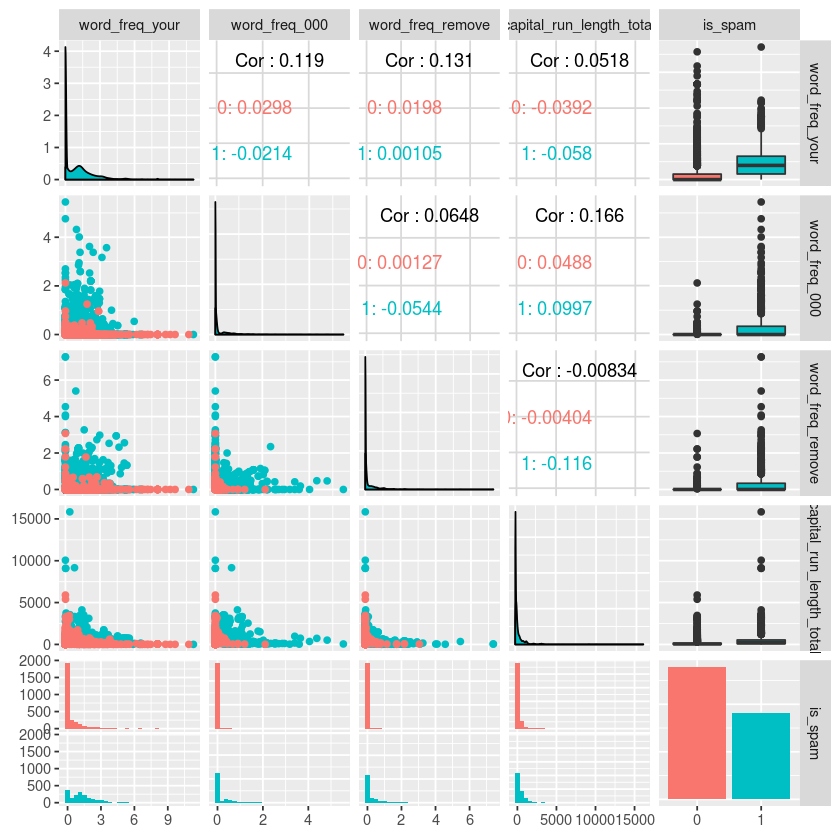

In [7]:
# correction : Histogram (or other relevant plot) per class (spam vs non-spam)
# correction : with ggplot2

#install.packages("ggplot2", repos = "http://cran.rstudio.com")
#install.packages("GGally", repos = "http://cran.rstudio.com")
library("ggplot2"); library("GGally")
ggpairs(spambase[,c(21,23,7,57,58)],aes(colour = is_spam))

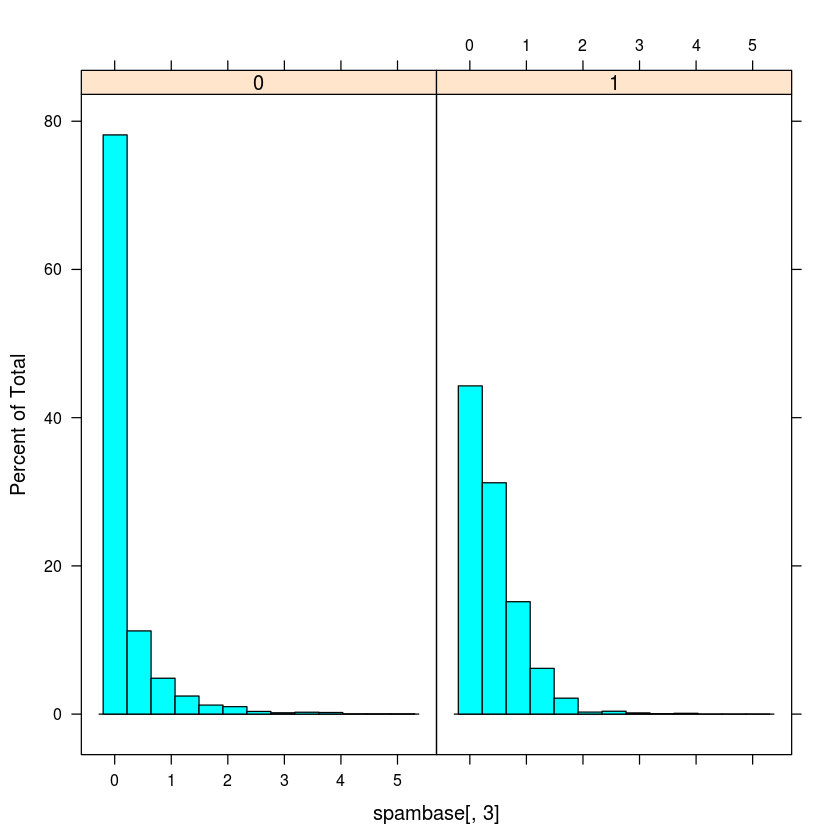

In [8]:
# correction : Histogram (or other relevant plot) per class (spam vs non-spam)
# correction : with lattice

library('lattice')
histogram(~ spambase[,3] | spambase$is_spam)

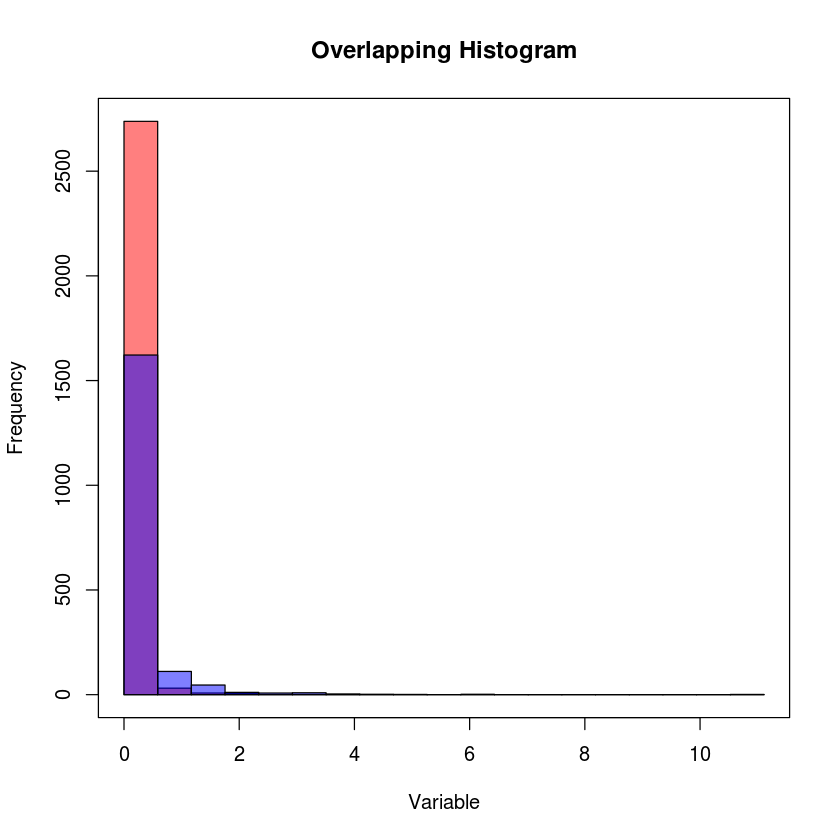

In [9]:
# correction : Histogram (or other relevant plot) per class (spam vs non-spam)
# correction : with no package

feat = 8
mf = max(spambase[,feat])
ls = seq(0,mf,length=20)
hist(spambase[spambase$is_spam==0,feat], col=rgb(1,0,0,0.5),xlim=c(0,max(spambase[,feat])), main='Overlapping Histogram', xlab='Variable',breaks=ls)
hist(spambase[spambase$is_spam==1,feat], col=rgb(0,0,1,0.5), add=T,breaks=ls)
box()

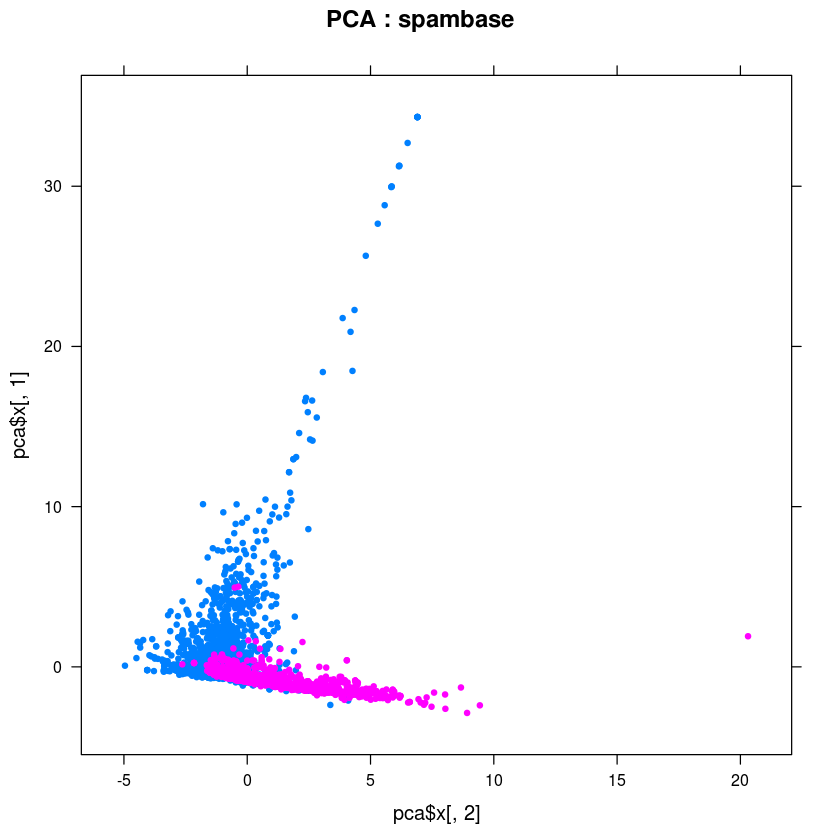

In [10]:
# bonus : PCA 
pca <- prcomp(spambase[, 1:57],center=TRUE,scale.=TRUE,retx=TRUE)
# install.packages("lattice", repos = "http://cran.rstudio.com")
library("lattice");
xyplot(pca$x[,1] ~ pca$x[,2], spambase, groups = spambase$is_spam, pch= 20, main="PCA : spambase")

## Classification : classifier, performance metrics, train set and test set

The goal of a classification task is to automatically assign data to predefined discrete
classes (here spam vs non-spam). The obtained model is often called a classifier. 

The most used performance metric for classification is the misclassification rate. In this notebook, we will use it but other performance metrics exist. Of course, each performance metric has its pros and cons.

The goal of supervised learning is to predict useful information. Therefore we must divide our dataset in two part :

* *train set* : From which we train our model, assuming we know the class labels
* *test set* : On which we test our model

Sometimes, when we want to validate parameters, a *validation set* is also used.

This train/test partition can be very simple (one sample in train set, one in test set, repeat) or more elaborate (10-fold cross-validation).

First, obtain the performance of a DT on the spambase dataset using a very simple partition. Also check the importance of each feature using the obtained DT. You can use packages *rpart* or *tree*.

Then plot the obtained tree using packages *rpart.plot*.

Finally, implement a 10-fold cross-validation for assessing your DT.

In [11]:
# correction : Simple data partition
halfsample <- floor(nrow(spambase)/2)
nsample <- nrow(spambase)
nFeat <- length(Feat_Names)
# first shuffle the data
spambaseS <- spambase[sample(nrow(spambase)),]
# then split the data and target
xtrain <- spambaseS[1 :halfsample ,-nFeat]
ytrain <- spambaseS[1 :halfsample , nFeat]
xtest <- spambaseS[(halfsample+1):nsample ,-nFeat]
ytest <- spambaseS[(halfsample+1):nsample , nFeat]
# data and target together
xytrain <- spambaseS[1 :halfsample , ]
xytest <- spambaseS[(halfsample+1):nsample , ]

In [12]:
# correction : Decision Tree
#install.packages("rpart", repos = "http://cran.rstudio.com")
library(rpart)  

# build the model
model<- rpart(is_spam~.,xytrain)
Y.hat<- predict(model,xytest[,-nFeat])

# apply standard threshold
Yhat = Y.hat[,2]>0.5

# build confusion matrix
Ytrue = ytest==1
T = table(Yhat,Ytrue)
T

# compute misclassification rate
Misclassification_rate = 1 - (T[1,1]+T[2,2])/sum(T)
Misclassification_rate

       Ytrue
Yhat    FALSE TRUE
  FALSE  1340  140
  TRUE    100  721

[1] 0.1043025

In [13]:
# correction : feature importance 
model$variable.importance

char_freq_exclamation           char_freq_dollar 
               360.6216297                189.5797301 
capital_run_length_longest             word_freq_free 
               186.8952964                161.8854292 
            word_freq_your              word_freq_all 
               139.6250301                112.4361838 
          word_freq_remove   capital_run_length_total 
                98.0790530                 61.3919552 
capital_run_length_average               word_freq_hp 
                60.8928336                 45.7934429 
             word_freq_hpl           word_freq_george 
                27.5102016                 25.1672588 
             word_freq_000         word_freq_business 
                21.9681350                 17.7069191 
            word_freq_labs               word_freq_85 
                11.7405819                 10.5716973 
         word_freq_meeting              word_freq_415 
                 9.3924655                  7.5512124 
             word_freq_857          word_freq_receive 
                 7.5512124                  6.8505852 
        word_freq_internet              word_freq_lab 
                 6.4243339                  5.8702909 
            word_freq_over        word_freq_addresses 
                 5.7854436                  5.6590083 
           word_freq_money           word_freq_credit 
                 5.4804682                  4.5670568 
         word_freq_address            char_freq_pound 
                 4.1103511                  1.8070904 
             word_freq_our           word_freq_people 
                 1.5845806                  1.4201824 
            word_freq_font            word_freq_order 
                 0.9035452                  0.7391470

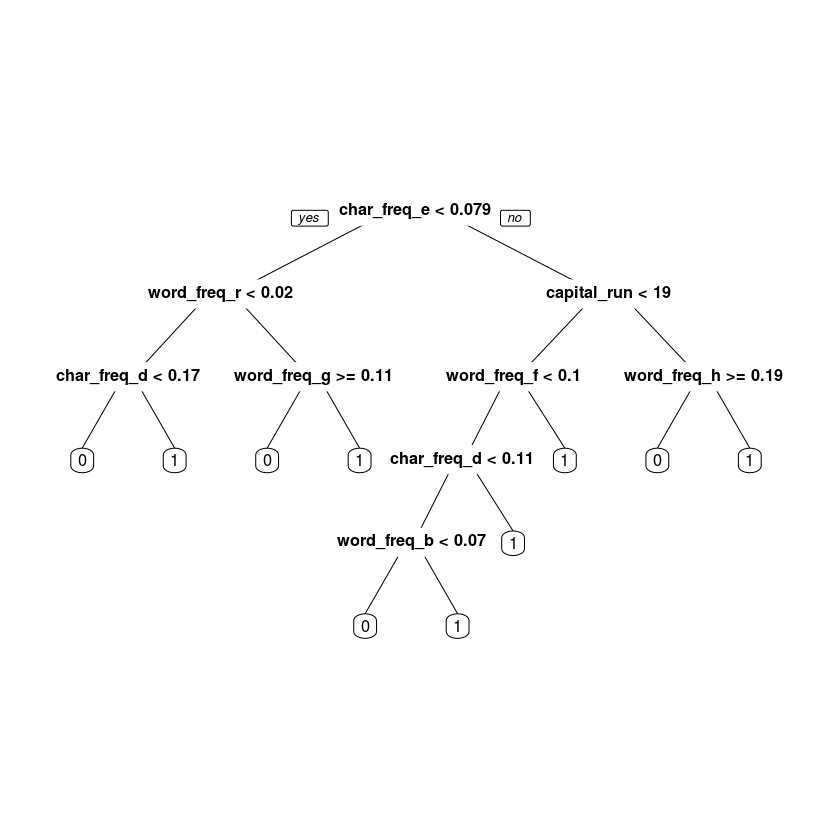

In [14]:
# correction : tree plot
#install.packages("rpart.plot", repos = "http://cran.rstudio.com")
library(rpart.plot)  ### Run install.packages("rpart.plot") to install
prp(model)

In [15]:
# correction : 10-fold cross-validation

# can be ordered to respect prior
spambase_shuffled = spambase[sample(nrow(spambase),replace=FALSE),]

# create a vector with fold assignation
infold = 1:nrow(spambase)%%10
infold[1:42]

[1] 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8
[39] 9 0 1 2

In [16]:
# correction : 10-fold cross-validation

Crates = numeric(10); f1010 = c(1:10,1:10)
for (i in 1:10){ #print(i)
    # built trainset and testset
    xytrain <- data.frame()
    xytest <- data.frame()
    trainFold = f1010[  i  :(i+6)] # 70% of data in trainset
    testFold  = f1010[(i+7):(i+9)] # 30% of data in testset
    for (j in trainFold){xytrain <- rbind(xytrain,spambase_shuffled[infold==j,])}
    for (j in testFold ){xytest  <- rbind(xytest ,spambase_shuffled[infold==j,])}
    # build model
    model<- rpart(is_spam~.,xytrain)
    PrY.hat<- predict(model,xytest[,-nFeat])
    # apply standard threshold
    Yhat = PrY.hat[,2]>0.5
    # compute classification rate
    Crates[i] = mean(Yhat==(xytest[,nFeat]==1))
}
mean(Crates)

[1] 0.8974963

## Ensemble learning : random forest

A random forest (RF) consists in an ensemble of multiple decision trees trained at the same time and predicting the class as the mode of the single-tree prediction.
It combines the *bagging* idea and random selection of features, which is different for each tree. Compared to DT, RF to overfit less and reduce the variance of the estimation. Here is an implementation helper (of course, multiple variants exist) :

* The number of trees is a compromise between training time and performance.
* Each tree is built on a subset of features, usually the squared root of the total number of features, drawn randomly.
* For a new sample, the predicted class is simply the mean of predicted probabilities on all trained trees.

Implement a random forest with five trees from your (simple data partition) DT. Try with 8 and 20 features per tree. Do not use the *randomForest* package.

Then, implement a 10-fold cross-validation for assessing your DT. Plot the performances according to the number of trained trees. At that point you can use the  *randomForest* package.

In [17]:
# correction : Random forest by hand
Crates = numeric(10); f1010 = c(1:10,1:10)
nf = 20
for (i in 1:10){ #print(i)
    # built trainset and testset
    xytrain <- data.frame()
    xytest <- data.frame()
    trainFold = f1010[  i  :(i+6)] # 70% of data in trainset
    testFold  = f1010[(i+7):(i+9)] # 30% of data in testset
    trainFold = f1010[  i  :(i+4)] # 70% of data in trainset
    testFold  = f1010[(i+5):(i+9)] # 30% of data in testset
    for (j in trainFold){xytrain <- rbind(xytrain,spambase_shuffled[infold==j,])}
    for (j in testFold ){xytest  <- rbind(xytest ,spambase_shuffled[infold==j,])}
    # build tree models
    Fset1 <- c(sample(1:53, nf),58)
    Fset2 <- c(sample(1:53, nf),58)
    Fset3 <- c(sample(1:53, nf),58)
    Fset4 <- c(sample(1:53, nf),58)
    Fset5 <- c(sample(1:53, nf),58)
    Fset6 <- c(sample(1:53, nf),58)
    Fset7 <- c(sample(1:53, nf),58)
    Fset8 <- c(sample(1:53, nf),58)
    Fset9 <- c(sample(1:53, nf),58)
    
    tree1 <- rpart(is_spam~.,xytrain[,Fset1])
    tree2 <- rpart(is_spam~.,xytrain[,Fset2])
    tree3 <- rpart(is_spam~.,xytrain[,Fset3])
    tree4 <- rpart(is_spam~.,xytrain[,Fset4])
    tree5 <- rpart(is_spam~.,xytrain[,Fset5])
    tree6 <- rpart(is_spam~.,xytrain[,Fset6])
    tree7 <- rpart(is_spam~.,xytrain[,Fset7])
    tree8 <- rpart(is_spam~.,xytrain[,Fset8])
    tree9 <- rpart(is_spam~.,xytrain[,Fset9])
    
    PrY.hat1 <- predict(tree1,xytest[,Fset1])
    PrY.hat2 <- predict(tree2,xytest[,Fset2])
    PrY.hat3 <- predict(tree3,xytest[,Fset3])
    PrY.hat4 <- predict(tree4,xytest[,Fset4])
    PrY.hat5 <- predict(tree5,xytest[,Fset5])
    PrY.hat6 <- predict(tree6,xytest[,Fset6])
    PrY.hat7 <- predict(tree7,xytest[,Fset7])
    PrY.hat8 <- predict(tree8,xytest[,Fset8])
    PrY.hat9 <- predict(tree9,xytest[,Fset9])
    
    Yhat1 = PrY.hat1[,2]>0.5
    Yhat2 = PrY.hat2[,2]>0.5
    Yhat3 = PrY.hat3[,2]>0.5
    Yhat4 = PrY.hat4[,2]>0.5
    Yhat5 = PrY.hat5[,2]>0.5
    Yhat6 = PrY.hat6[,2]>0.5
    Yhat7 = PrY.hat7[,2]>0.5
    Yhat8 = PrY.hat8[,2]>0.5
    Yhat9 = PrY.hat9[,2]>0.5
    
    votes = (Yhat1+Yhat2+Yhat3+Yhat4+Yhat5+Yhat6+Yhat7+Yhat8+Yhat9)
    Yhat = votes>=5
    
    # compute classification rate
    Crates[i] = mean(Yhat==(xytest[,nFeat]==1))
    
    
}
mean(Crates)

[1] 0.8995605

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



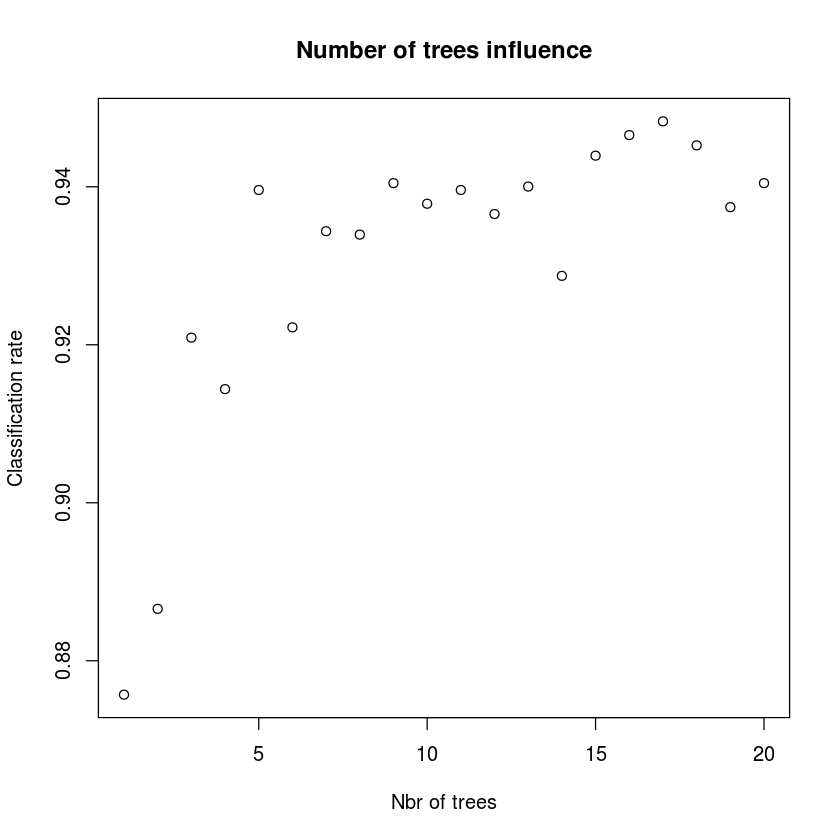

In [18]:
# correction : using randomForest package
#install.packages("randomForest", repos = "http://cran.rstudio.com")
library("randomForest")
nTree = 20
Crates = integer(nTree)
for (i in 1:nTree){ #print(i)
    RF = randomForest(x=xtrain,y=ytrain,xtest,ytest,ntree=i)
    Crates[i] = (RF$test$confusion[1,1]+RF$test$confusion[2,2])/length(ytest)
    }
plot(Crates,main = "Number of trees influence",xlab = "Nbr of trees",ylab = "Classification rate") 

## Ensemble learning : Boosting

Boosting produces a serie of classifiers (here $T$ trees with $1 \leq t \leq T$). The training set used for each classifier (here tree) of the serie is chosen based on the performance of the earlier classifier(s) in the serie. Unlike bagging (like RF), the different classifier cannot be trained in parallel as they depend of the previous one(s). Here is an implementation helper (multiple variants exist) :

* The number of trees is a compromise between training time and performance. Here we will train 15 trees.
* Starting probability of picking each sample $i$ (with $1 \leq i \leq N$) is 1/N (the number of samples in train set). After the first tree, it becomes simply proportional to the weight $w_i$.
* The misclassification metric ($misc$) on the train set is also linearly weighted by $w_i$. We will call it $wmisc$.
* It allows to compute $\alpha_t = log((1-wmisc[t])/wmisc[t])$. It represents a confidence on that tree (or classifier).
* Then $\alpha_t$ allows to update $w_i = w_i*exp(alpha_t*misc_t)$.
* Finally, the predicted values are the average of all trees, linearly weighted by $\alpha_t$.
* The trees are usually depth-forced : add *control=tree.control(Ntrain,mincut=10)* as a parameter to *tree()*.

For this exercise, we will use the *tree* package. It is therefore easier to recode the spam labels as -1/+1.

In [19]:
nsample <- nrow(spambase)
data(spambase)
spambase$is_spam = (2*as.integer(spambase$is_spam)-3) 

Now compare, in terms of misclassifcation, a regular tree against a boosted 15-trees model. You can re-use the code of the ''very simple partition'' as for the first tree we designed.

In [20]:
# correction : Tree vs boosted trees comparison

#install.packages("tree", repos = "http://cran.rstudio.com")
library(tree)

# Simple data partition
halfsample <- floor(nrow(spambase)/2)
nFeat <- length(Feat_Names)
Nsample<-nrow(spambase)
# first shuffle the data
spambaseS <- spambase[sample(nrow(spambase)),]
# then split the data 
train <- spambaseS[1 :halfsample , ]
test <- spambaseS[(halfsample+1):Nsample , ]
Ntrain <- dim(train)[1]
Ntest  <- dim(test )[1]

w<-rep(1/Ntrain,Ntrain)

# first compute a regular tree misclassification rate
set.seed(555)
tree.model <-tree(is_spam ~ ., train,
                  control=tree.control(Ntrain,mincut=10))
pred <- sign(predict(tree.model,test))
misc.tree <- sum(as.integer(test$is_spam != sign(pred)))/length(pred)


# boosting initialisation
T<-15

wmisc<-rep(NA,T);
alpha<-rep(NA,T)
pred.test<-rep(0,Ntest)
for (t in 1:T)
{
    set.seed(554+t)
 
    # generate new sample set accoring to their weights
    I<-sample(seq(1,Ntrain),prob=w,replace=TRUE)
    
    # Build a new tree accordingly
    tree.model <-tree(is_spam ~ ., train[I,],control=tree.control(Ntrain,mincut=10))
    
    # predict
    pred.train <-sign(predict(tree.model,train))
    wmisc[t] <- sum(w*as.integer(train$is_spam != pred.train))/sum(w)
    
    # update weigths
    alpha[t]<-log((1-wmisc[t])/wmisc[t])
    w<- w*exp(alpha[t]*as.integer(train$is_spam != pred.train))
    
    # update predictions
    pred.test<-pred.test+alpha[t]*predict(tree.model,test)
}

# compute overall boosting misclassification rate
misc.boosting <- mean(test$is_spam != sign(pred.test))


cat("Misclassification single tree=",misc.tree,"\n")
cat("Misclassification boosting=",misc.boosting,"\n")


Misclassification single tree= 0.10691 
Misclassification boosting= 0.05562799 
